
# Policy Paper Theme & Cluster Analysis

This notebook analyzes policy papers published by the Wilfried Martens Centre using modern NLP tools. It assigns topics to each paper based on semantic similarity, clusters the resulting themes, and visualizes key dynamics across the corpus.

### What this notebook does:
- Cleans and tokenizes the full text of each article
- Matches documents to predefined themes using embeddings
- Clusters themes into macro-topic areas
- Generates visual summaries (e.g. heatmaps, word clouds, dendrograms)
- Exports CSV tables with per-paper and per-theme insights

### Inputs:
- `martens_texts.csv` – cleaned full-text of papers

### Outputs:
- Summary CSVs for top words, themes, clusters
- Visual assets (`.png`) for cluster heatmaps and distributions


In [36]:
# core
import pandas as pd
import numpy as np
import re


# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import textwrap

# theming
from sentence_transformers import SentenceTransformer
import itertools

# clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram

# words
from collections import defaultdict, Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [37]:
#load data
df = pd.read_csv("data/martens_texts.csv")

### Stopwords
This section defines a custom set of stopwords (based on subsequent frequency analysis) in addition to the default ENGLISH_STOP_WORDS from sklearn. These include frequent but semantically empty terms found across the Martens papers (e.g., "policy", "research", "European").
A cleaning function is defined to:
* Lowercase text;
* Remove links and non-letter characters;
* Filter out stopwords and short tokens.

This helps prepare the text for accurate keyword frequency analysis.

In [38]:
# stopwords
custom_stopwords = {
    "martens", "centre", "pdf", "accessed", "access", "act", "action", "age", "analysis", "approach", "april",
    "area", "areas", "article", "august", "author", "available", "based", "case", "central",
    "challenges", "change", "clear", "common", "countries", "country", "critical", "current",
    "different", "document", "does", "ensure", "european", "europes", "eus", "example", "external", "february", "focus",
    "framework", "future", "general", "group", "groups", "growth", "high", "impact", "important", "including",
    "increase", "information", "institute", "institutions", "issues", "january", "july", "june", "key", "level", "main",
    "major", "make", "march", "measures", "member", "members", "need", "needs", "new", "november", "number", "october",
    "open", "order", "paper", "people", "policies", "policy", "political", "potential", "process",
    "programme", "project", "projects", "provide", "public", "recent", "region", "report", "research", "right", "role",
    "second", "sector", "significant", "single", "state", "states", "studies", "systems", "terms", "time", "times",
    "union", "use", "used", "view", "way", "wilfried", "work", "world", "years",
    "especially", "levels", "risk", "far", "december", "particularly", "transition", "just", "end", "specific", "year",
    "affairs",  "euro", "working", "existing", "efforts", "september", "press", "increasing",
    "figure", "extended", "strong",  "interests", "context", "peoples", "likely", "result", "better", "model",
    "history", "set", "given", "possible", "issue", "long", "means", "rules", "lack", "changes", "following", "internal",
    "despite", "introduction", "good", "necessary", "regional", "study", "fact", "include",
     "effects", "influence", "partners", "according", "increased",  "million", "address",
    "capacity",  "challenge", "life", "past", "institutional", "communication", "governments",
     "authors", "middle",  "concerns", "place", "related", "able", "joint",  "regions",
    "force", "remain", "progress", "individual", "deal", "essential", "source", "provided",
    "period", "forces", "develop", "large", "like", "free", "implementation", "materials", "point", "share", "direct",
    "standards",  "certain", "value", "parliamentary",
    "various", "initiatives", "remains", "united", "agenda", "situation", "left", "service", "opportunities",
    "agreement", "average", "making", "building", "question", "lower", "treaty", "local", "particular",
    "limited", "position", "debate", "majority", "actors", "increasingly", "needed", "help", "create", "term",
    "space", "plan", "community", "billion", "ing", "lead", "threat", "funds",
    "creative", "did", "real", "journal", "low",
    "fundamental", "concept", "participation", "overall",
    "tion", "led", "positive", "negative", "survey",
    "currently", "effective", "seen", "longterm", "decisions",
    "sectors", "think", "present", "committee", "demand", "greater", "control", "threats",
    "europeans",
     "europe", "post", "doi", "content", "pro", "anti", "today", "class", "raw", "publication", "established", "review",
    "decades", "early", "status", "core", "euv", "response", "strengthening", "leadership", "respondents", "results",
    "perspective", "ability", "idea", "crucial", "growing", "understanding", "processes", "conditions", "final", "total",
    "hand", "regarding", "longer", "developed", "self", "actions", "sense", "form", "scale", "considered", "similar",
    "significantly", "factors", "taken", "der", "short", "problems", "goals", "small", "best", "century", "eurostat",
    "balance", "establish", "responsibility", "agency", "table", "relevant", "having", "effect", "reduce", "distribution",
    "principles", "creating", "taking", "initiative", "old", "language", "principle", "sources", "positions", "requires",
    "conference", "play", "achieve", "relationship", "trends", "addition", "leading", "recommendations", "problem",
    "quality", "cases", "field", "furthermore", "called", "face", "outside", "aim", "difficult", "continue", "office",
    "build", "comes", "promote", "developments", "reasons", "practice", "fully", "compared", "required", "consequences",
    "line", "require", "special", "strengthen", "depth", "ways", "opportunity", "assessment", "shared", "great", "eds",
    "basis", "improve", "contribute", "additional", "proposals", "commitment", "expected", "van", "complex", "allow",
    "original", "step", "successful", "forward", "mechanism", "attention", "brief", "regard", "department", "linked",
    "adopted", "discussion", "cross", "changing", "providing", "net", "highly", "creation", "turn", "largest",
    "coordination", "conclusion", "objectives", "shows", "explained", "finally", "personal", "using", "differences",
    "course", "extent", "instead", "opinion", "return", "instance", "start", "ibid", "implications", "enhance",
    "addressing", "corresponding", "clearly", "reason", "rising", "half", "approaches", "broader", "keywords",
    "consider", "close", "provides", "includes", "wmces", "reports", "later", "wide", "day", "largely", "basic",
    "pre", "base", "recently", "words", "vol", "tions", "held", "wing", "focused", "aimed", "attributed", "defined",
    "specified", "distributed", "account", "medium", "note", "matters", "makes", "look", "von", "pages", "views",
    "little", "prime", "closer", "kter", "criteria", "html", "references", "ment", "TRUE", "months", "things",
    "sagepub", "publications", "sage", "index", "summary", "license", "org", "meet", "said", "join", "formal"
}
stop_words = set(ENGLISH_STOP_WORDS).union(custom_stopwords)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)  # replace unwanted chars with a space
    text = re.sub(r"\s+", " ", text)       # normalize multiple spaces to one
    text = text.strip()                    # remove leading/trailing spaces
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)





### Extracting Frequent Words per Article
After cleaning, the top 20 most frequent words in each article, along with their counts are generated. The result is exported as a CSV for use in tables or dashboards. The code also adds a paper_id for future analysis.

In [39]:
df = df.reset_index(drop=True)
df["paper_id"] = df.index + 1

records = []

def get_top_words(text, n=20):
    if pd.isna(text) or not isinstance(text, str):
        return []
    counter = Counter(text.split())
    return counter.most_common(n)

for _, row in df.iterrows():
    top_words = get_top_words(row["clean_text"])
    for word, count in top_words:
        records.append({
            "paper_id": row["paper_id"],
            "filename": row["filename"],
            "word": word,
            "count": count
        })

top_words_df = pd.DataFrame(records)
top_words_df.to_csv("data/paper_top_words.csv", index=False)
display(top_words_df.head())


,paper_id,filename,word,count
0,1,navigating-through-renewed-economic-uncertaint...,young,39
1,1,navigating-through-renewed-economic-uncertaint...,epp,36
2,1,navigating-through-renewed-economic-uncertaint...,youth,19
3,1,navigating-through-renewed-economic-uncertaint...,elections,17
4,1,navigating-through-renewed-economic-uncertaint...,economic,16


### Basic Descriptives
Basic length metrics for each article are computed:
* Total characters
* Word count
* Approximate sentence count (via dot splits)

This is done for both the cleaned and original texts. This allows us to explore document variability and determine the numeric impact of cleaning.

In [40]:
#basic descriptives
df["char_count"] = df["text"].apply(lambda x: len(str(x)))
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["sentence_count"] = df["text"].apply(lambda x: len(str(x).split(".")))

desc_df = df[["char_count", "word_count", "sentence_count"]].describe()
desc_df.to_csv("data/text_descriptives_summary.csv")

display(desc_df)


,char_count,word_count,sentence_count
count,1.870000e+02,187.000000,187.000000
mean,8.792463e+04,12794.866310,941.315508
std,1.497418e+05,21851.512828,1617.624676
min,1.833000e+03,143.000000,43.000000
25%,2.370000e+04,3432.000000,253.000000
50%,3.201800e+04,4515.000000,351.000000
75%,7.297850e+04,10489.000000,650.000000
max,1.160459e+06,165229.000000,9905.000000


In [41]:
#clean text descriptives
df["char_count_clean"] = df["clean_text"].apply(lambda x: len(str(x)))
df["word_count_clean"] = df["clean_text"].apply(lambda x: len(str(x).split()))
df["sentence_count_clean"] = df["clean_text"].apply(lambda x: len(str(x).split(".")))

desc_df = df[["char_count_clean", "word_count_clean", "sentence_count_clean"]].describe()
desc_df.to_csv("data/text_descriptives_summary.csv")

display(desc_df)


,char_count_clean,word_count_clean,sentence_count_clean
count,187.000000,187.000000,187.0
mean,40900.069519,4768.588235,1.0
std,69545.516161,7981.327083,0.0
min,408.000000,43.000000,1.0
25%,10804.500000,1296.500000,1.0
50%,14883.000000,1790.000000,1.0
75%,34563.000000,4095.500000,1.0
max,545639.000000,60985.000000,1.0


### Word Frequency
To visualise the most common concepts in the entire corpus:
* All cleaned texts are combined;
* Word frequency count is calculated;
* A word cloud is generated.

This helps reveal dominant language patterns and informs the stop word selection.

In [42]:
#frequency
all_words = " ".join(df["clean_text"]).split()
from collections import Counter
top_words = Counter(all_words).most_common(500)

print(top_words)

freq_df = pd.DataFrame(top_words, columns=["word", "count"])

freq_df.to_csv("data/top_words_frequency.csv", index=False)

[('economic', 4992), ('security', 4049), ('defence', 3828), ('commission', 3826), ('parties', 3577), ('ukraine', 3545), ('national', 3436), ('china', 3305), ('energy', 3097), ('social', 3013), ('party', 2899), ('market', 2816), ('global', 2752), ('council', 2457), ('international', 2440), ('support', 2342), ('digital', 2333), ('war', 2330), ('parliament', 2323), ('russia', 2307), ('nato', 2171), ('sustainability', 2134), ('financial', 2116), ('development', 2106), ('strategic', 2072), ('foreign', 2046), ('trade', 1997), ('democracy', 1975), ('data', 1974), ('democratic', 1950), ('integration', 1867), ('western', 1815), ('military', 1773), ('climate', 1735), ('crisis', 1713), ('cooperation', 1655), ('government', 1635), ('media', 1618), ('economy', 1600), ('citizens', 1591), ('labour', 1528), ('values', 1528), ('power', 1513), ('russian', 1508), ('nuclear', 1496), ('law', 1483), ('migration', 1472), ('politics', 1427), ('enlargement', 1413), ('non', 1388), ('investment', 1387), ('univer

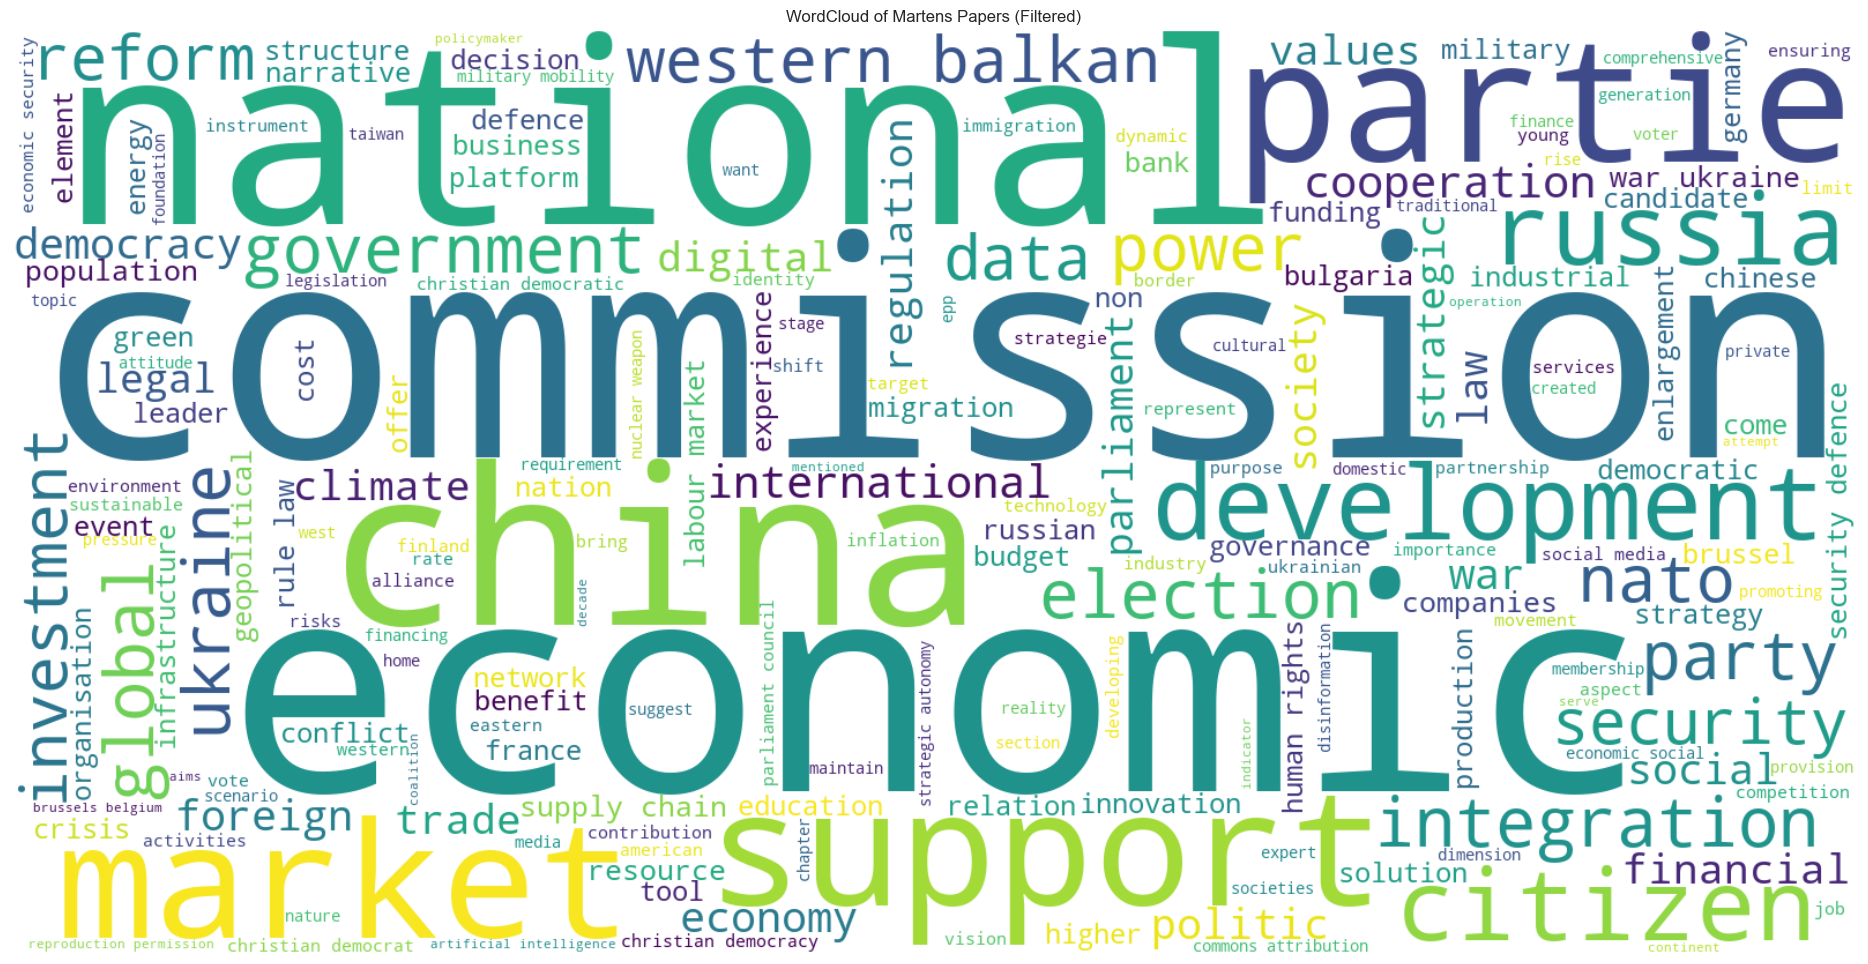

In [43]:
#wordcloud
text = " ".join(df["clean_text"])

filtered_words = [word for word in text.split() if word not in custom_stopwords]

wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(" ".join(filtered_words))

plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Martens Papers (Filtered)")
plt.savefig("images/wordcloud.png", dpi=900, bbox_inches="tight")
plt.show()



### Thematic Structure
To organise and analyse the content of Martens Centre publications, a set themes based on the frequency analysis and initial exploratory analysis are defined. They are sorted based on subsequent clustering analysis for ease of use.

In [44]:
themes = {
# Cluster 0 – Society, Politics & Information Order
    "Elections and Parties": [
        "elections", "voters", "campaign", "civil", "party", "polls"],
    "European Identity and Values": [
        "democracy", "freedom", "identity", "liberal", "equality","rule of law", "judiciary", "conservative", "christian"],
    "Financial Stability": [
        "fiscal", "monetary", "debt", "inflation", "eurozone", "ecb", "liquidity", "market"],
    "Populism and Extremism": [
        "populism", "extremist", "radical", "eurosceptic"],
# Cluster 1 – Geopolitics & Strategic Regions
    "Asia and Indo-Pacific": [
        "asia", "asean", "indo-pacific", "vietnam", "philippines", "singapore","thailand", "malaysia", "indonesia", "japan", "korea"],
    "Baltic Region": [
        "estonia", "latvia", "lithuania", "vilnius", "riga", "tallinn","baltic", "baltics", "baltic region"],
    "China": [
        "china", "chinese", "beijing", "taiwan", "hong kong", "asia", "xi", "xi jinping", "ccp", "south china sea", "cpec", "belt and road"],
    "EU Enlargement": [
        "enlargement", "accession", "candidate countries", "eastern partnership", "pre-accession"],
    "Latin America and the Caribbean": [
        "latin america", "brazil", "argentina", "caribbean", "mercosur","venezuela", "south america", "andes", "mexico"],
    "Middle East and North Africa": [
        "mena", "middle east", "iran", "iraq", "syria", "turkey", "gulf","saudi", "egypt", "morocco", "yemen", "north africa", "israel", "palestine"],
    "Nordic Region": [
        "finland", "sweden", "norway", "denmark", "iceland", "arctic", "nordic", "nordics"],
    "Russia and Ukraine": [
        "ukraine", "ukrainian", "russia", "russian", "war", "invasion", "donbas", "crimea","moscow", "kremlin", "putin", "zelensky", "occupied"],
    "South Caucasus and Central Asia": [
        "georgia", "armenia", "azerbaijan", "kazakhstan", "uzbekistan", "kyrgyzstan", "tajikistan", "turkmenistan", "silk road", "caucasus"],
    "Western Balkans": [
        "serbia", "kosovo", "albania", "north macedonia", "montenegro","bosnia", "herzegovina", "balkan", "western balkans"],
# Cluster 2 – Economy, Energy & Innovation
    "AI & Technology": [
        "ai", "technology", "innovation", "computers", "automation", "tech", "digital", "digitalisation", "data"],
    "Climate and Environment": [
        "climate", "carbon", "environment", "biodiversity", "ecosystems", "weather", "green", "emissions", "sustainability", "decarbonisation"],
    "Education, Research and Youth": [
        "education", "university", "schools", "erasmus", "knowledge", "learning", "youth", "young", "generations", "students", "academic", "science"],
    "Energy": [
        "energy", "renewables", "solar", "wind", "nuclear", "hydrogen", "electricity", "fossil fuels", "gas", "grid", "storage"],
    "Industrial and Economic Policy": [
        "competitiveness", "investment", "innovation", "industrial policy", "manufacturing", "growth", "productivity", "economy", "economic", "gdp", "industry"],
    "Infrastructure and Transport": [
        "infrastructure", "transport", "rail", "connectivity", "logistics", "mobility", "corridors", "roads", "public transport", "cars"],
    "Trade": [
        "exports", "imports", "trade", "quotas", "trade deal", "tariffs"],
# Cluster 3 – Social Europe & Labour Dynamics
    "Demographics": [
        "ageing", "demographic", "elderly", "seniors", "pension", "care", "retirement"],
    "Labour Market": [
        "employment", "unemployment", "workforce", "jobs","wages", "reskilling","upskilling", "labour mobility"],
    "Migration": [
        "migration", "border", "refugees", "deportation", "asylum", "visa"],
    "Social Protection and Housing": [
        "social", "welfare", "benefits", "insurance", "housing", "urban", "rent", "affordability", "development", "social inclusion", "homelessness"],
# Cluster 4 – Security & Information Order
    "Defence and Military": [
        "defence", "security", "military", "armed forces", "nuclear", "deterrence", "weapons", "warfare", "army"],
    "Disinformation & Cybersecurity": [
        "disinformation", "propaganda", "hybrid", "cybersecurity", "cyber", "malware", "hacking"],
    "Transatlantic Relations": [
        "transatlantic", "nato", "us", "usa", "america", "american", "washington", "alliance", "atlanticism", "biden", "trump"]
}
theme_keywords_records = []

for theme, keywords in themes.items():
    for keyword in keywords:
        theme_keywords_records.append({
            "theme": theme,
            "word": keyword
        })

theme_keywords_df = pd.DataFrame(theme_keywords_records)
theme_keywords_df.to_csv("data/theme_words.csv", index=False)
display(theme_keywords_df.head())



,theme,word
0,Elections and Parties,elections
1,Elections and Parties,voters
2,Elections and Parties,campaign
3,Elections and Parties,civil
4,Elections and Parties,party


### Thematic Tagging
In this section, sentence embeddings and cosine similarity assign themes to each article based on its cleaned content. This is done through the all-mpnet-base-v2 model from SentenceTransformers to embed both the articles and the pre-defined theme keyword lists. For each article, cosine similarity between its embedding and each theme embedding are computed. A theme is considered relevant to an article if its similarity score exceeds the threshold of 0.40. This results in a multi-label thematic classification per article. Then frequency of each theme is aggregated and counted.

This technique enables a semantic clustering of articles into thematic categories, allowing for more nuanced content analysis beyond keyword matching.

In [45]:
#embeddings for themes and docs

model = SentenceTransformer('all-mpnet-base-v2')

theme_names = list(themes.keys())
theme_embeddings = model.encode([" ".join(keywords) for keywords in themes.values()])

docs = df["clean_text"].tolist()
doc_embeddings = model.encode(docs, show_progress_bar=True)


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [56]:
# paper theming
similarity_matrix = cosine_similarity(doc_embeddings, theme_embeddings)

threshold = 0.40

paper_themes = []
for similarities in similarity_matrix:
    matched_themes = [theme_names[i] for i, sim in enumerate(similarities) if sim > threshold]
    paper_themes.append(matched_themes)

df["themes"] = paper_themes

all_themes = [theme for paper in df["themes"] for theme in paper]
theme_counts = Counter(all_themes)
theme_counts_df = pd.DataFrame(theme_counts.items(), columns=["theme", "paper_count"]).sort_values("paper_count", ascending=False)

display(theme_counts_df.head())
theme_counts_df.to_csv("data/theme_counts.csv", index=False)



rows = []
for _, row in df.iterrows():
    for theme in row["themes"]:
        rows.append({
            "paper_id": row["paper_id"],
            "filename": row["filename"],
            "theme": theme
        })

theme_paper_df = pd.DataFrame(rows)
theme_paper_df.to_csv("data/paper_theme_table.csv", index=False)

# Preview

display(theme_paper_df.head())



,theme,paper_count
9,Transatlantic Relations,73
0,Populism and Extremism,60
1,Climate and Environment,60
13,Industrial and Economic Policy,56
6,Russia and Ukraine,53


,paper_id,filename,theme
0,1,navigating-through-renewed-economic-uncertaint...,Populism and Extremism
1,1,navigating-through-renewed-economic-uncertaint...,Climate and Environment
2,1,navigating-through-renewed-economic-uncertaint...,"Education, Research and Youth"
3,1,navigating-through-renewed-economic-uncertaint...,Social Protection and Housing
4,2,the-ukraine-war-and-its-implications-for-europ...,EU Enlargement


 ### Theme Co-occurrence Analysis
This section examines how often different themes appear together in the same article, providing insight into thematic overlaps and interdependencies. Pairwise co-occurrences of themes assigned to each article are counted. A co-occurrence matrix is created, where each cell represents how many times a pair of themes co-appeared.

The result is visualized using a heatmap, highlighting the most frequently co-occurring theme pairs. This visualization helps reveal which policy areas are closely interlinked across the corpus (e.g., "Migration" and "Labour Market", or "Russia and Ukraine" and "Defence"

In [47]:
# theme co occurrences
co = defaultdict(int)

for paper_themes in df["themes"]:
    for t1, t2 in itertools.combinations(sorted(set(paper_themes)), 2):
        co[(t1, t2)] += 1

co_df = pd.DataFrame([
    {"theme_1": k[0], "theme_2": k[1], "count": v}
    for k, v in co.items()
]).sort_values(by="count", ascending=False)


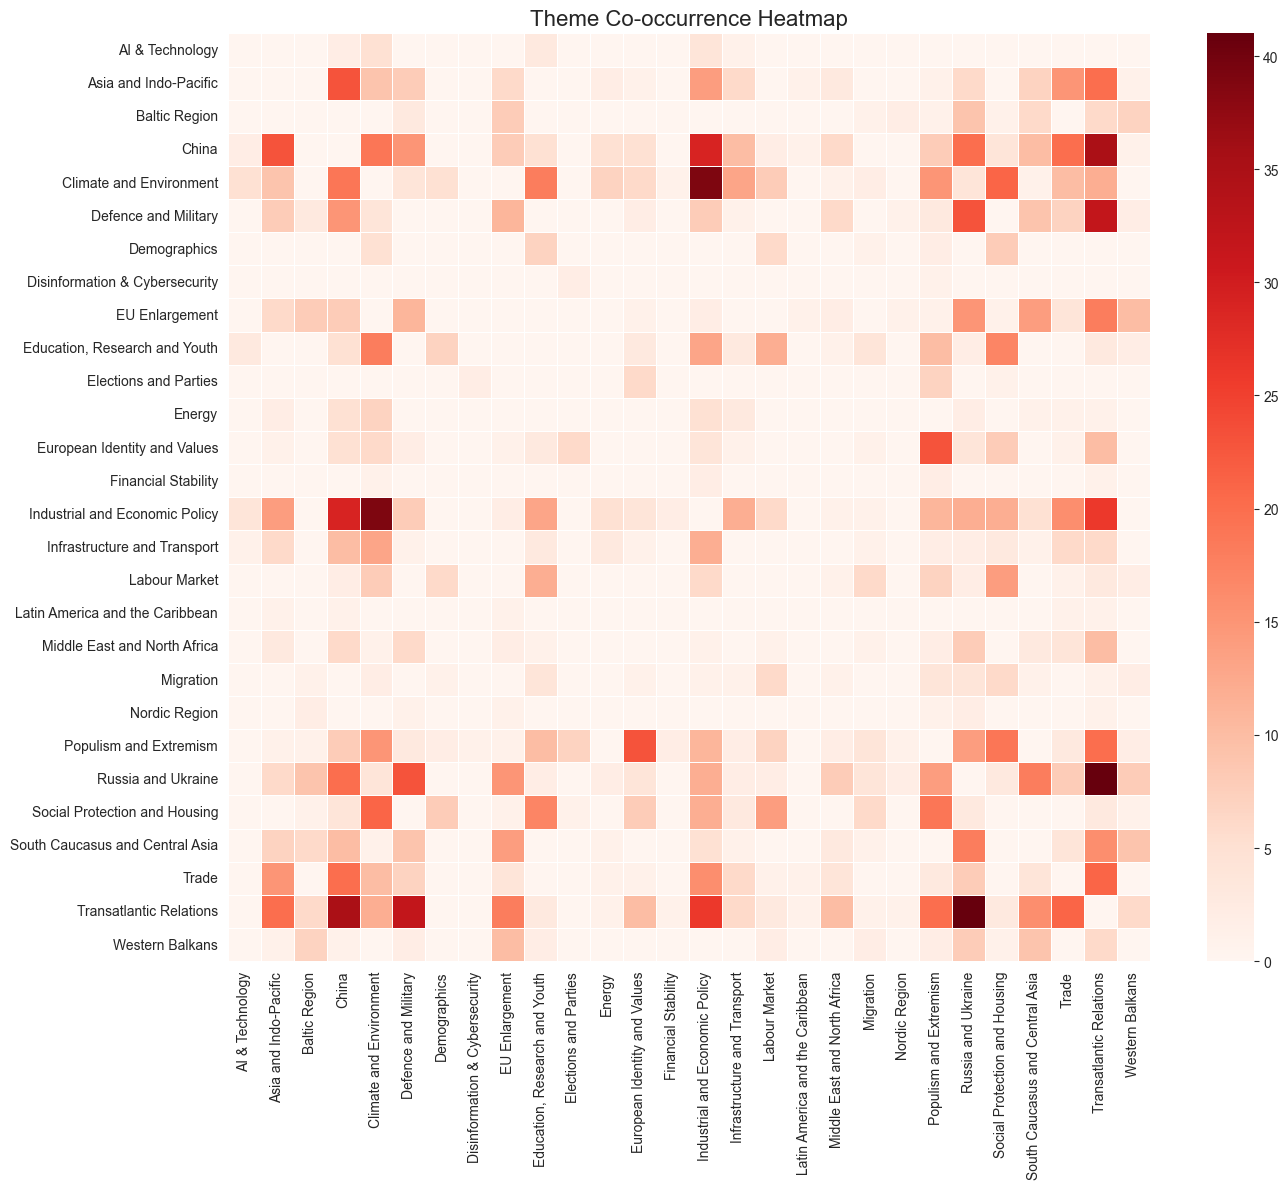

In [48]:
#co occurance heatmap
theme_list = sorted(set(itertools.chain.from_iterable(df["themes"])))
co_matrix = pd.DataFrame(0, index=theme_list, columns=theme_list)

for (t1, t2), count in co.items():
    co_matrix.loc[t1, t2] = count
    co_matrix.loc[t2, t1] = count

for theme in theme_list:
    co_matrix.loc[theme, theme] = 0

plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, cmap="Reds", linewidths=0.5)
plt.title("Theme Co-occurrence Heatmap", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("images/theme_cooccurrence_heatmap.png", dpi=900, bbox_inches="tight")
plt.show()

### Theme Clustering
To better understand how themes relate to one another, the subsequent cells conduct clustering and dendrogram visualization to the semantic embeddings of all themes:

**Hierarchical dendrogram** is created through Ward linkage with Euclidean distance to generate a dendrogram based on sentence-transformer embeddings of the theme keyword sets. This dendrogram reveals the semantic proximity between themes, with closely related topics appearing near each other in the tree.

**Agglomerative clustering**

To formalize the thematic groupings, Agglomerative Clustering with 5 clusters is applied. Each theme is assigned to one cluster, enabling summarisation the thematic landscape into macro-clusters that reflect broader issue domains (e.g., geopolitics, economy, social policy).

Use of ward linkage with Euclidean distance, was informed by experimentation with several different methods. In summary, this combination was chosen because it minimizes intra-cluster variance and is well-suited for high-dimensional sentence embeddings. 5 Clusters instead of 4 (as suggested by the dendogram) are chose for better thematic grouping. This approach helps to both explore and define the structure of research themes in a data-driven manner.


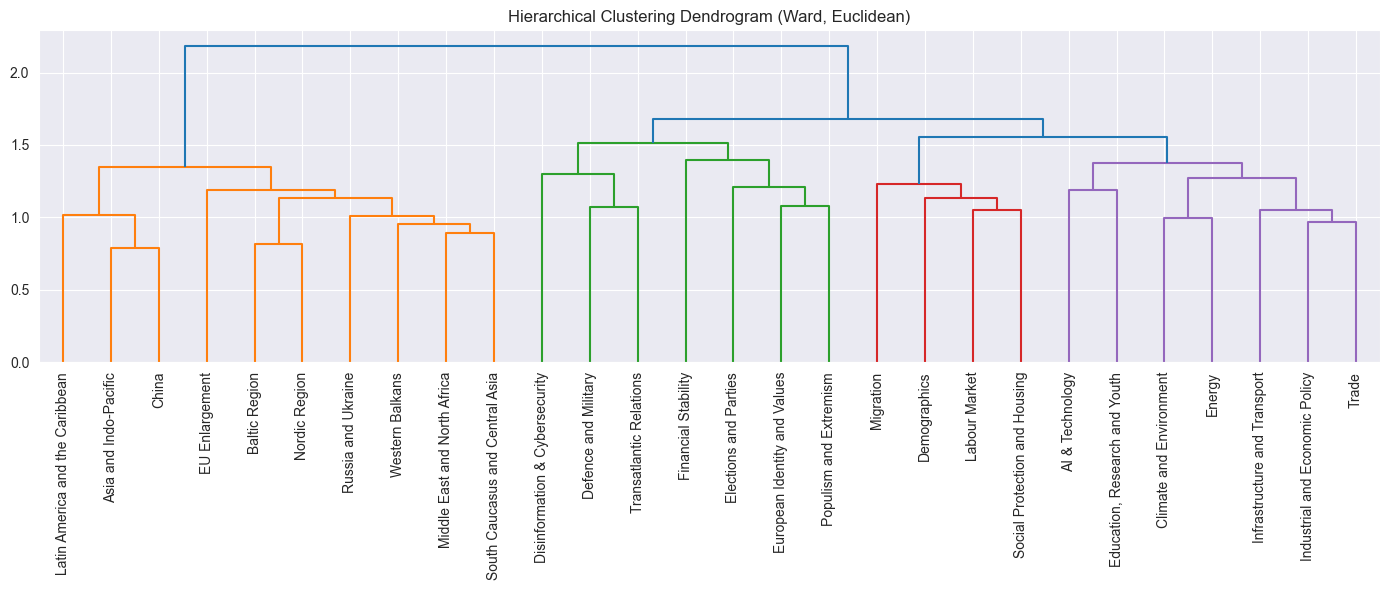

In [49]:
# cluster dendogram
linkage_matrix = linkage(theme_embeddings, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, labels=theme_names, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Ward, Euclidean)")
plt.tight_layout()
plt.savefig("images/hierarchical_clustering_dendrogram.png", dpi=900, bbox_inches="tight")
plt.show()




In [50]:
#Clustering

agg = AgglomerativeClustering(
    n_clusters=5,
    linkage='ward'
)

labels = agg.fit_predict(theme_embeddings)

theme_to_cluster = dict(zip(theme_names, labels))
cluster_to_themes = defaultdict(list)
for theme, cluster in zip(theme_names, labels):
    cluster_to_themes[cluster].append(theme)

print("\n=== Agglomerative Theme Clusters ===")
for cluster_id in sorted(cluster_to_themes):
    print(f"\nCluster {cluster_id} ({len(cluster_to_themes[cluster_id])} themes):")
    for theme in sorted(cluster_to_themes[cluster_id]):
        print(f"  - {theme}")





=== Agglomerative Theme Clusters ===

Cluster 0 (4 themes):
  - Elections and Parties
  - European Identity and Values
  - Financial Stability
  - Populism and Extremism

Cluster 1 (10 themes):
  - Asia and Indo-Pacific
  - Baltic Region
  - China
  - EU Enlargement
  - Latin America and the Caribbean
  - Middle East and North Africa
  - Nordic Region
  - Russia and Ukraine
  - South Caucasus and Central Asia
  - Western Balkans

Cluster 2 (7 themes):
  - AI & Technology
  - Climate and Environment
  - Education, Research and Youth
  - Energy
  - Industrial and Economic Policy
  - Infrastructure and Transport
  - Trade

Cluster 3 (4 themes):
  - Demographics
  - Labour Market
  - Migration
  - Social Protection and Housing

Cluster 4 (3 themes):
  - Defence and Military
  - Disinformation & Cybersecurity
  - Transatlantic Relations


In [51]:
# cluster naming
cluster_names = {
    0: "Society, Politics & Information Order",
    1: "Geopolitics & Strategic Regions",
    2: "Economy, Energy & Innovation",
    3: "Social Europe & Labour Dynamics",
    4: "Defence & Transatlantic Security"
}

cluster_theme_records = []

for theme, cluster_id in theme_to_cluster.items():
    cluster_theme_records.append({
        "cluster_id": cluster_id,
        "cluster_name": cluster_names[cluster_id],
        "theme": theme
    })

cluster_theme_df = pd.DataFrame(cluster_theme_records)
cluster_theme_df = cluster_theme_df.sort_values(by=["cluster_id", "cluster_name", "theme"])

# Save to CSV
cluster_theme_df.to_csv("data/theme_clusters.csv", index=False)
display(cluster_theme_df.head())


,cluster_id,cluster_name,theme
0,0,"Society, Politics & Information Order",Elections and Parties
1,0,"Society, Politics & Information Order",European Identity and Values
2,0,"Society, Politics & Information Order",Financial Stability
3,0,"Society, Politics & Information Order",Populism and Extremism
4,1,Geopolitics & Strategic Regions,Asia and Indo-Pacific


### Assigning Dominant Clusters to Each Paper
After thematically tagging each paper, dominant cluster labels are assigned based on the most frequent theme cluster among its matched themes. This allows to group papers under broader topic umbrellas, making the dataset easier to explore and summarize.

* The previously created theme_to_cluster mapping (from agglomerative clustering) is used in this step.
* Each paper is assigned to the most common cluster among its associated themes.
* The resulting paper_cluster and human-readable cluster_name are added to the DataFrame.
* Finally, the cell prints out the number of papers per cluster.

This step supports subsequent analyses like visualizations, or paper recommendations by theme group.

In [52]:
# assign dominant cluster to each paper
paper_cluster_assignments = []
for theme_list in df["themes"]:

    cluster_list = [theme_to_cluster.get(theme) for theme in theme_list if theme in theme_to_cluster]
    if cluster_list:
        dominant_cluster = Counter(cluster_list).most_common(1)[0][0]
        paper_cluster_assignments.append(dominant_cluster)
    else:
        paper_cluster_assignments.append(None)

df["paper_cluster"] = paper_cluster_assignments
df["cluster_name"] = df["paper_cluster"].map(cluster_names)  # cluster_names should match new clustering

cluster_freq = Counter(df["cluster_name"].dropna())
cluster_df_named = pd.DataFrame(
    sorted(cluster_freq.items(), key=lambda x: x[1], reverse=True),
    columns=["cluster_name", "paper_count"]
)

display(cluster_df_named)
cluster_df_named.to_csv("data/cluster.csv", index=False)


,cluster_name,paper_count
0,Geopolitics & Strategic Regions,58
1,"Economy, Energy & Innovation",48
2,"Society, Politics & Information Order",43
3,Social Europe & Labour Dynamics,17
4,Defence & Transatlantic Security,9


### Identifying Key Papers per Cluster
To better understand each thematic cluster, the top 3 most representative papers per cluster are identified based on how strongly they align with that cluster’s themes.
* Each paper receives a match score: the number of assigned themes that fall within its dominant cluster.
* Papers are grouped by their assigned cluster_name and sorted by match score in descending order.
* The top 3 papers from each cluster are selected and saved as top_representative_papers.csv.

These representative papers help select representative, example policy papers for further exploratory analysis.

In [53]:
# identify key papers per cluster

df["paper_cluster"] = paper_cluster_assignments
df["cluster_name"] = df["paper_cluster"].map(cluster_names)

def count_cluster_themes(themes, cluster_id):
    if cluster_id is None:
        return 0
    return sum(1 for theme in themes if theme_to_cluster.get(theme) == cluster_id)

df["match_score"] = df.apply(lambda row: count_cluster_themes(row["themes"], row["paper_cluster"]), axis=1)

top_papers_per_cluster = (
    df[df["paper_cluster"].notna()]
    .sort_values(["paper_cluster", "match_score"], ascending=[True, False])
    .groupby("cluster_name")
    .head(3)[["paper_id", "filename", "cluster_name", "match_score"]]
)

display(top_papers_per_cluster)
top_papers_per_cluster.to_csv("data/top_representative_papers.csv", index=False)


,paper_id,filename,cluster_name,match_score
17,18,why-we-still-need-parties-the-resilience-of-eu...,"Society, Politics & Information Order",3
24,25,how-mainstream-parties-can-defend-democracy-by...,"Society, Politics & Information Order",3
55,56,christian-democracy-conservatism-and-the-chall...,"Society, Politics & Information Order",3
41,42,the-future-of-transatlantic-relations_Lete.pdf,Geopolitics & Strategic Regions,6
90,91,intersecting-paths-strategic-autonomy-enlargem...,Geopolitics & Strategic Regions,5
125,126,navigating-demographic-dynamics-strategies-for...,Geopolitics & Strategic Regions,5
35,36,navigating-through-renewed-economic-uncertaint...,"Economy, Energy & Innovation",5
51,52,the-7ds-digitalisation-extended__Digitalisatio...,"Economy, Energy & Innovation",5
7,8,the-7ds-digitalisation-in-depth__Digitalisatio...,"Economy, Energy & Innovation",4
141,142,navigating-demographic-dynamics-strategies-for...,Social Europe & Labour Dynamics,4


### Theme Frequency Heatmap
This section visualizes how frequently each theme appears within the five identified thematic clusters. By counting the number of papers that mention each theme within a cluster, we can gain insight into which topics dominate or overlap across thematic areas.

To ensure meaningful comparison across clusters of different sizes, the heatmap is normalized by the total number of papers in each cluster. This allows us to highlight the relative prominence of themes rather than their raw frequency.

The resulting heatmap provides a visual summary of the thematic structure of the Martens Centre archive, helping identify clusters that are more specialized, diversified, or identify themes not primarily assigned to a cluster but also relevant to the cluster.

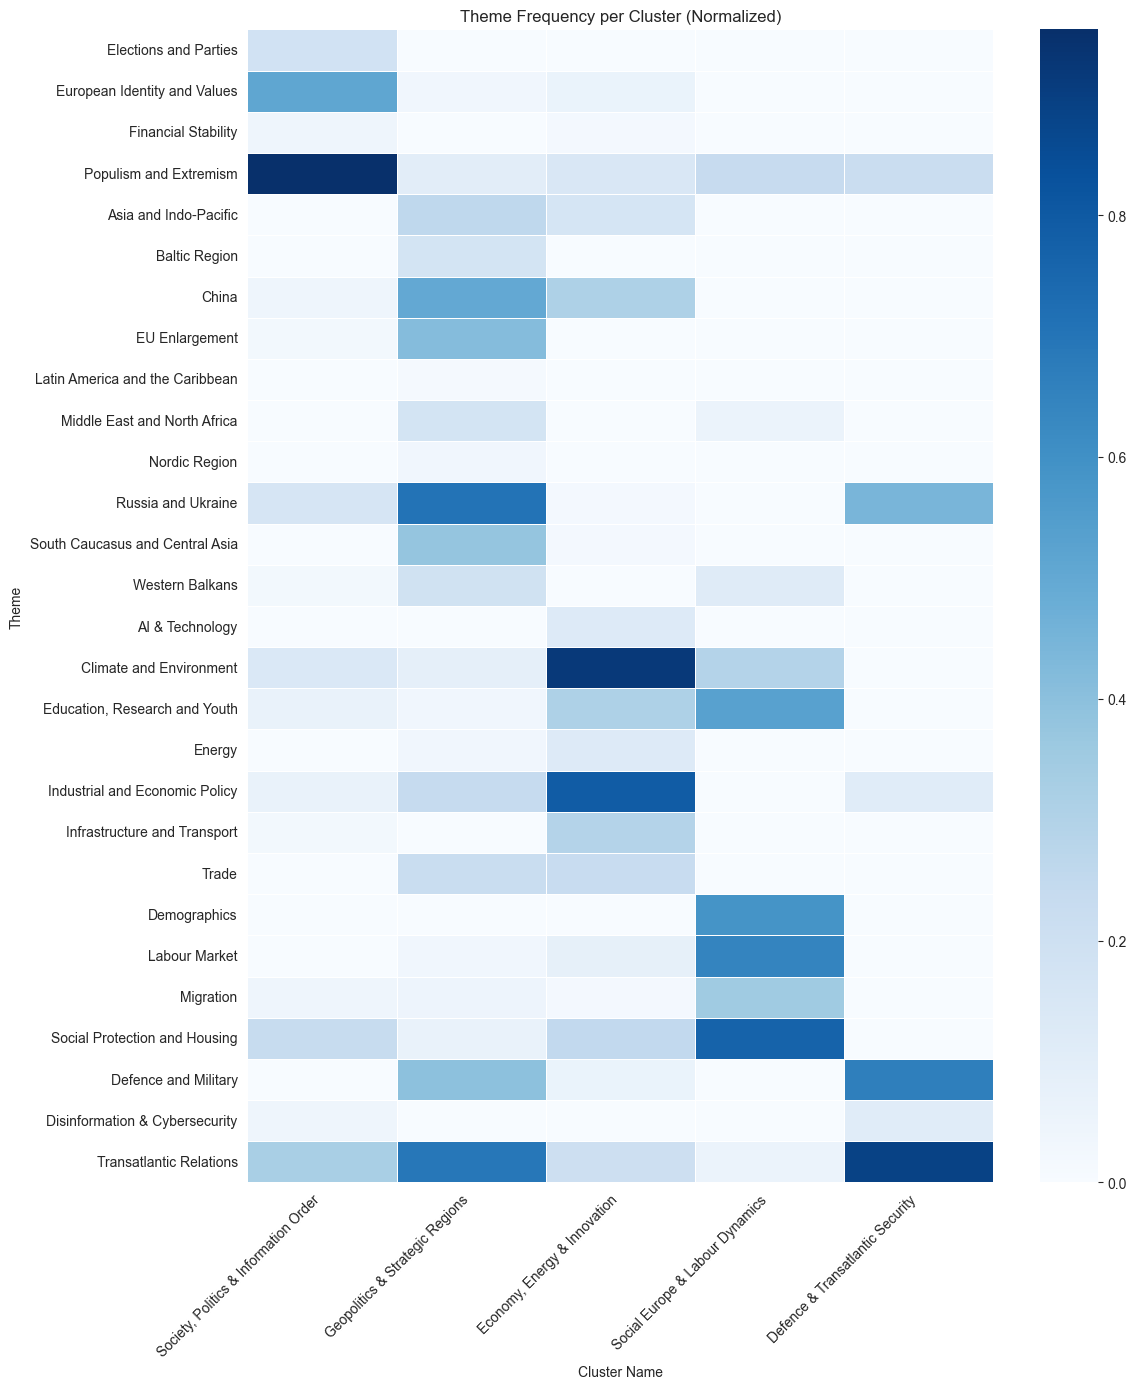

In [54]:
# theme frequency heatmap
cluster_ids = list(cluster_names.keys())
cluster_labels = [cluster_names[i] for i in cluster_ids]
theme_cluster_counts = pd.DataFrame(0, index=themes.keys(), columns=cluster_labels)

for _, row in df.iterrows():
    cluster = row["paper_cluster"]
    if cluster is None:
        continue
    cluster_name = cluster_names.get(cluster)
    for theme in row["themes"]:
        if theme in themes:  # Only count known themes
            theme_cluster_counts.loc[theme, cluster_name] += 1

normalize = True
if normalize:
    cluster_sizes_named = df["cluster_name"].value_counts().to_dict()
    for cname in theme_cluster_counts.columns:
        if cname in cluster_sizes_named:
            theme_cluster_counts[cname] = theme_cluster_counts[cname] / cluster_sizes_named[cname]

plt.figure(figsize=(12, 14))
sns.heatmap(theme_cluster_counts, cmap="Blues", annot=False, linewidths=0.5)
plt.title("Theme Frequency per Cluster (Normalized)" if normalize else "Theme Frequency per Cluster")
plt.xlabel("Cluster Name")
plt.ylabel("Theme")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("images/theme_frequency_heatmap.png", dpi=600)
plt.show()



### Visualizing Theme Frequency Within Clusters
This section produces a stacked bar chart showing how frequently each theme appears within its assigned cluster across the entire document set.

Each bar represents one of the five clusters, broken down by the number of times a theme—belonging to that cluster—was tagged across all papers. Key implementation features:
* Only themes whose cluster assignment matches the paper's cluster are counted.
* Colors are assigned uniquely to each theme for clarity.
* Direct labels are added for bars with sufficient height; smaller bars have grouped overflow labels shown above the chart.
*
This visualization is useful for understanding the internal structure of each cluster: which themes dominate, which are secondary, and how tightly clustered topics align with document assignments. Thus, it serves as the penultimate summary of the study giving a clear view of what themes and issues have been most covered by the Martens Centre since 2023.

The resulting chart is saved as theme_frequency_within_clusters.png for reuse in reports or presentations.

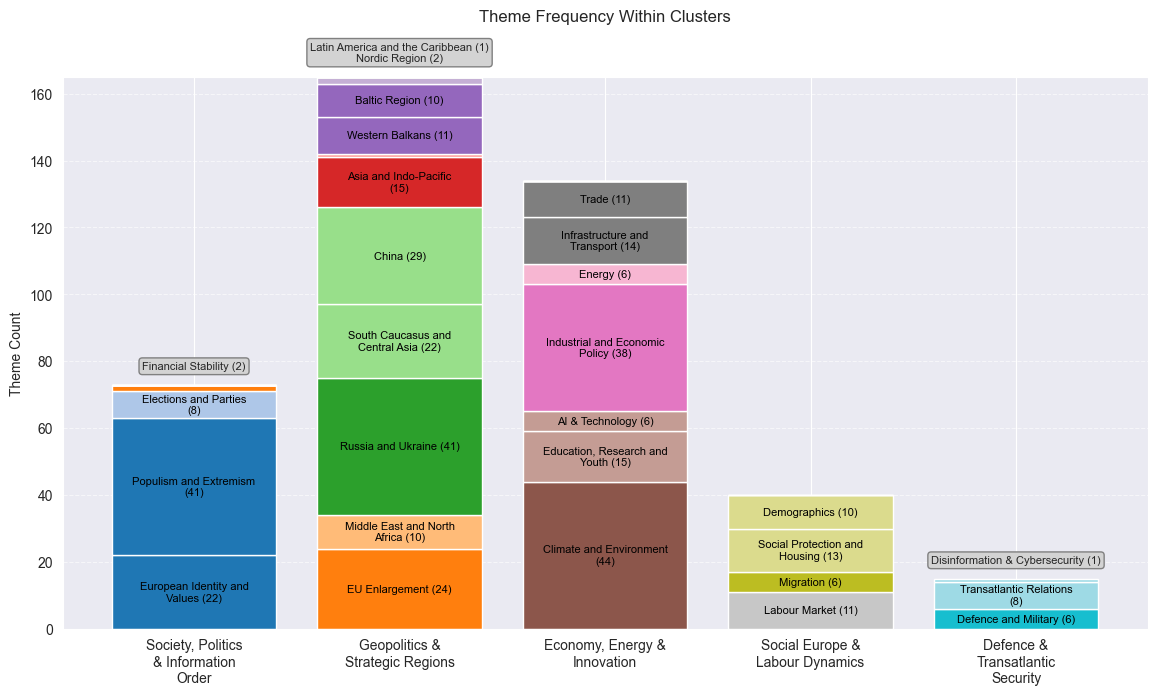

In [55]:
#theme frequency within clusters
theme_to_cluster_name = {theme: cluster_names[theme_to_cluster[theme]] for theme in theme_names}

cluster_theme_counts = {cluster_names[cid]: {} for cid in cluster_names}
for _, row in df.iterrows():
    cluster_id = row["paper_cluster"]
    if pd.isna(cluster_id):
        continue
    cluster_name = cluster_names[cluster_id]
    for theme in row["themes"]:
        if theme_to_cluster_name.get(theme) == cluster_name:
            cluster_theme_counts[cluster_name][theme] = cluster_theme_counts[cluster_name].get(theme, 0) + 1

cluster_bars_df = pd.DataFrame(cluster_theme_counts).fillna(0).T  # clusters as rows

theme_list = cluster_bars_df.columns.tolist()
cmap_base = plt.colormaps.get_cmap('tab20')
cmap = cmap_base(np.linspace(0, 1, len(theme_list)))
theme_colors = {theme: mcolors.to_hex(cmap[i]) for i, theme in enumerate(theme_list)}


plt.figure(figsize=(14, 8))
bottom = np.zeros(len(cluster_bars_df))
cluster_names_order = cluster_bars_df.index.tolist()

overflow_labels = [[] for _ in cluster_names_order]

for theme in theme_list:
    values = cluster_bars_df[theme].values
    bars = plt.bar(cluster_names_order, values, bottom=bottom, label=theme, color=theme_colors[theme])

    for i, bar in enumerate(bars):
        height = bar.get_height()
        label = f"{theme} ({int(height)})"
        if height > 3:
            plt.text(
                x=bar.get_x() + bar.get_width() / 2,
                y=bar.get_y() + height / 2,
                s=textwrap.fill(label, width=24),
                ha="center", va="center",
                fontsize=8,
                color="black"
            )
        elif height > 0:
            overflow_labels[i].append(label)

    bottom += values

for i, texts in enumerate(overflow_labels):
    if texts:
        plt.text(
            x=i,
            y=bottom[i] + 4,
            s="\n".join(texts),
            ha="center", va="bottom",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="gray")
        )


wrapped_names = ["\n".join(textwrap.wrap(name, 18)) for name in cluster_names_order]
plt.xticks(ticks=range(len(cluster_names_order)), labels=wrapped_names, rotation=0)

plt.ylabel("Theme Count")
plt.title("Theme Frequency Within Clusters", pad=40)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.subplots_adjust(top=0.80)
bbox_inches="tight"
plt.savefig("images/theme_frequency_within_clusters.png", dpi=1200, bbox_inches="tight")
plt.show()


